# Create flying node graph
This Notebook will create the graph we will use for flying our drone. We do it once so we don't have to do it everytime we load the simulator.

## Imports

In [1]:
import networkx as nx
nx.__version__

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from planning_utils import heuristic, create_grid
import time

%matplotlib inline

## Load Data

In [2]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


# Random sampling method

In [3]:
from sampling import Sampler

print('Sampling')
t0 = time.time()
sampler = Sampler(data)
polygons = sampler.polygons

nodes = sampler.sample(3000)
print('Sampling took {0} for {1}'.format(time.time()-t0, len(nodes)))

Sampling
Sampling took 0.5691404342651367 for 1981


In [24]:
# Create a grid map of the world
# This will create a grid map at 1 m above ground level
# Define a flying altitude (feel free to change this)
drone_altitude = 5
safety_distance = 3
grid, _, north_offset, east_offset = create_grid(data, drone_altitude, safety_distance)

## Create the graph by connecting the Nodes

In [17]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
    
import numpy.linalg as LA
from sklearn.neighbors import KDTree

def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                dist = LA.norm(np.array(n2) - np.array(n1))
                g.add_edge(n1, n2, weight=dist)
    return g

print('Creating Graph')
t0 = time.time()
g = create_graph(nodes, 10)
print('Graph took {0} seconds to build'.format(time.time()-t0))

Creating Graph
Graph took 312.6441514492035 seconds to build


In [26]:
print('Grid dimensions: ', grid.shape)
print('Original nodes {0}'.format(len(nodes)))
print('Graph nodes: %5d' % len(g.nodes))
print('Graph edges: %5d' % len(g.edges))

Grid dimensions:  (921, 921)
Original nodes 1981
Graph nodes:  1966
Graph edges:  8536


In [19]:
import pickle

# Dump the graph with Pickle
pkl_filename = 'graph.random_sampling.p'

try:
    with open(pkl_filename, 'wb+') as pfile:
        print('Saving to pickle file ', pkl_filename)
        pickle.dump(
        {
            'graph': g,
        },
        pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to ', pkl_filename, ':', e)

print('done')

Saving to pickle file  graph.random_sampling.p
done


## Load the Graph from pickle

In [20]:
pkl_filename = 'graph.random_sampling.p'
with open(pkl_filename, "rb") as pfile:
    print('Reading pickle')
    dist_pickle = pickle.load(pfile)

    g = dist_pickle["graph"]

print('done')

Reading pickle
done


## Visualize Graph

start


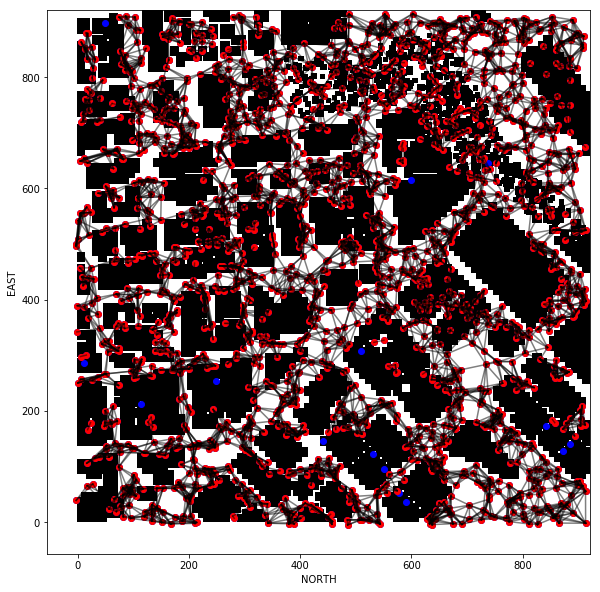

...done


In [21]:
import matplotlib.pyplot as plt

print('start')
fig = plt.figure(figsize=(10,10))

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1]-emin, n2[1]-emin], [n1[0]-nmin, n2[0]-nmin], 'black', alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1]-emin, n1[0]-nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1]-emin, n1[0]-nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

print("...done")

## A*

In [57]:
from planning_utils import a_star_graph

rnd = np.random.randint(len(g.nodes))
start = list(g.nodes)[rnd]
print('Start: ', rnd)
rnd = np.random.randint(len(g.nodes))
print('Goal: ', rnd)
goal = list(g.nodes)[rnd]

path, cost = a_star_graph(g, heuristic, start, goal)
print(len(path), path)

path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

Start:  272
Goal:  81
Found a path.
11 [(-197.52077994532038, -113.82158290350134, 17.184737031090282), (-170.29811853540932, -139.31327827990083, 12.653116451770517), (-122.97805344023985, -127.84151150970922, 9.520239659756617), (-91.90863875770722, -65.48169068624054, 8.723988660935387), (-5.846933077243705, -5.835469744393265, 9.636936450027564), (66.2203104629777, 30.177203670709332, 2.645005448192337), (79.18462654192905, -17.00203921352727, 14.542512421024572), (168.36090108079264, -28.63450464399915, 8.711144537856157), (172.85826012398917, 49.9935186392193, 13.586508537108537), (171.08276567530936, 64.26253588050258, 1.3391022234647187), (175.78366385057916, 146.71724922084468, 4.025793568851044)]
(-197.52077994532038, -113.82158290350134, 17.184737031090282) (-170.29811853540932, -139.31327827990083, 12.653116451770517)
(-170.29811853540932, -139.31327827990083, 12.653116451770517) (-122.97805344023985, -127.84151150970922, 9.520239659756617)
(-122.97805344023985, -127.841511

## Visualize Path

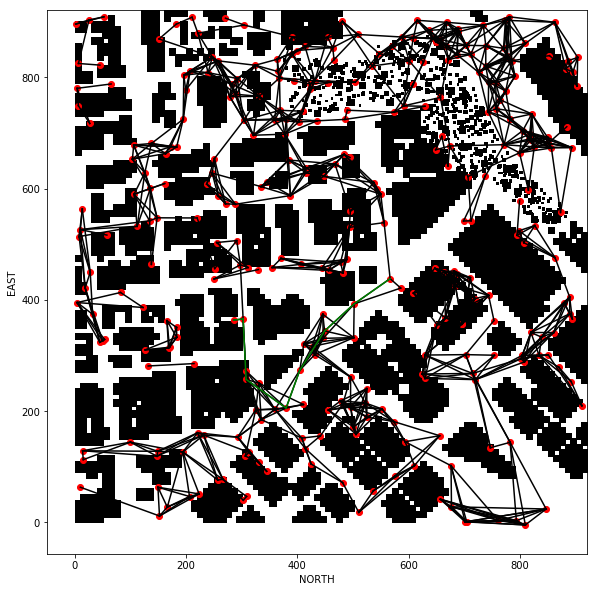

...done


In [29]:
fig = plt.figure(figsize=(10,10))

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

print("...done")